The fold caustic expansion to first order satisfies (https://ui.adsabs.harvard.edu/abs/1986ApJ...310..568B/abstract )

$$\tau(x_I,y_I) = \tau_0 + \tau_x x_I + \tau_y y_I\\
+\frac{1}{2!}\tau_{xx} x_I^2 + \frac{1}{2}\tau_{yy} y_I^2 + \tau_{xy}(\tau_{xx},\tau_{yy}) x_I y_I\\
+\frac{1}{3!} \tau_{xxx} x_I^2\,,$$

where the first three terms can be set to zero, without loss of generality, because (a) the overall fermat potential $\tau_0$ is not directly measurable, and (b) we can define the image-plane coordinate system such that the potential is expanded at the origin and the origin maps to the origin in the source plane (i.e., $\vec \theta_0=\vec \beta_0=\vec \theta_0-\vec \alpha_0=(0,0)$).


Here the potential is expanded at around the critical point such that $\det |\partial \vec \beta/\partial \vec \theta|=0$, which yields $\tau_{xy}(\tau_{xx},\tau_{yy})=\pm (\tau_{xx} \tau_{yy})^{1/2}$. The effective fermat potential is then

$$\tau(x_I,y_I) = \frac{1}{2!}\tau_{xx} x_I^2 + \frac{1}{2!}\tau_{yy} y_I^2 + (\tau_{xx}\tau_{yy})^{1/2} x_I y_I +\frac{1}{3!} \tau_{xxx} x_I^3\,,$$

which is equivalent to expanding the deflection potential as

$$\psi(x_I,y_I) =\frac{1}{2!}\psi_{xx} x_I^2 + \frac{1}{2!}\psi_{yy} y_I^2 + ((1-\psi_{xx})(1-\psi_{yy}))^{1/2} x_I y_I +\frac{1}{3!} \psi_{xxx} x_I^3 $$

In [2]:
import numpy as np
import jax.numpy as jnp
import jax.scipy.spatial.transform
rotation = jax.scipy.spatial.transform.Rotation
import jax
import herculens as hcl
import helens
import pylab as plt
from caustics import FoldCausticPotential, CausticExpansion, create_rotation_matrix
from grid import create_grid
import scienceplots
plt.style.use(['science','ieee'])
# Enable jax double precision:
jax.config.update('jax_enable_x64', True)

In [ ]:
# LENS MASS MODEL
kwargs_lens_list = [{'theta_E': 1.5, 'e1': 0.1, 'e2': 0.05, 'center_x': 0.0, 'center_y': 0.0}]
lens_mass_model = hcl.LensModel(lens_model_list=['SIE'], z_lens=0.5, z_source=2.0)

In [8]:
# GRID
xmin, xmax, ymin, ymax = -5, 5, -5, 5; nx, ny = 100, 100
pixel_grid, grid_x, grid_y, x, y = create_grid(xmin, xmax, ymin, ymax, nx, ny)
# Compute the magnifications:
mu = lens_mass_model.magnification(x, y, kwargs_lens_list)
Mu = lens_mass_model.magnification(grid_x, grid_y, kwargs_lens_list)
# Compute the image positions:
x_src, y_src = 0.05, 0.0
image_positions = fold_caustic_potential.image_positions(x_src, y_src, **kwargs_lens_list[0])
# Compute numerically
ray_shooting_func = lens_mass_model.ray_shooting
lens_eq_solver = helens.LensEquationSolver(grid_x, grid_y, ray_shooting_func)
beta   = jnp.array([x_src, y_src])
img, src = lens_eq_solver.solve(beta, kwargs_lens_list, nsolutions=2, niter=5, nsubdivisions=8)

In [9]:
caustic_expansion = CausticExpansion(lens_mass_model, kwargs_lens_list)
x0, y0 = 0.0, 0.0
v1, v2, lambda1, lambda2 = caustic_expansion.get_inverse_magnification_eigenvectors(x0, y0)
nabla_detA, nabla_detA_rot = caustic_expansion.get_nabla_detA(x0, y0)
R=create_rotation_matrix(vec_original=nabla_detA, vec_target=jnp.array([1.0, 0.0]))
f_ij, f_ijk = caustic_expansion.get_derivatives_to_third(x0, y0, R=R)

/tmp/ipykernel_1206337/369909921.py:16: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(image_positions[:,0], image_positions[:,1], marker='x', color='cyan', s=50, edgecolor='black', label='Images (analytical)') # Images


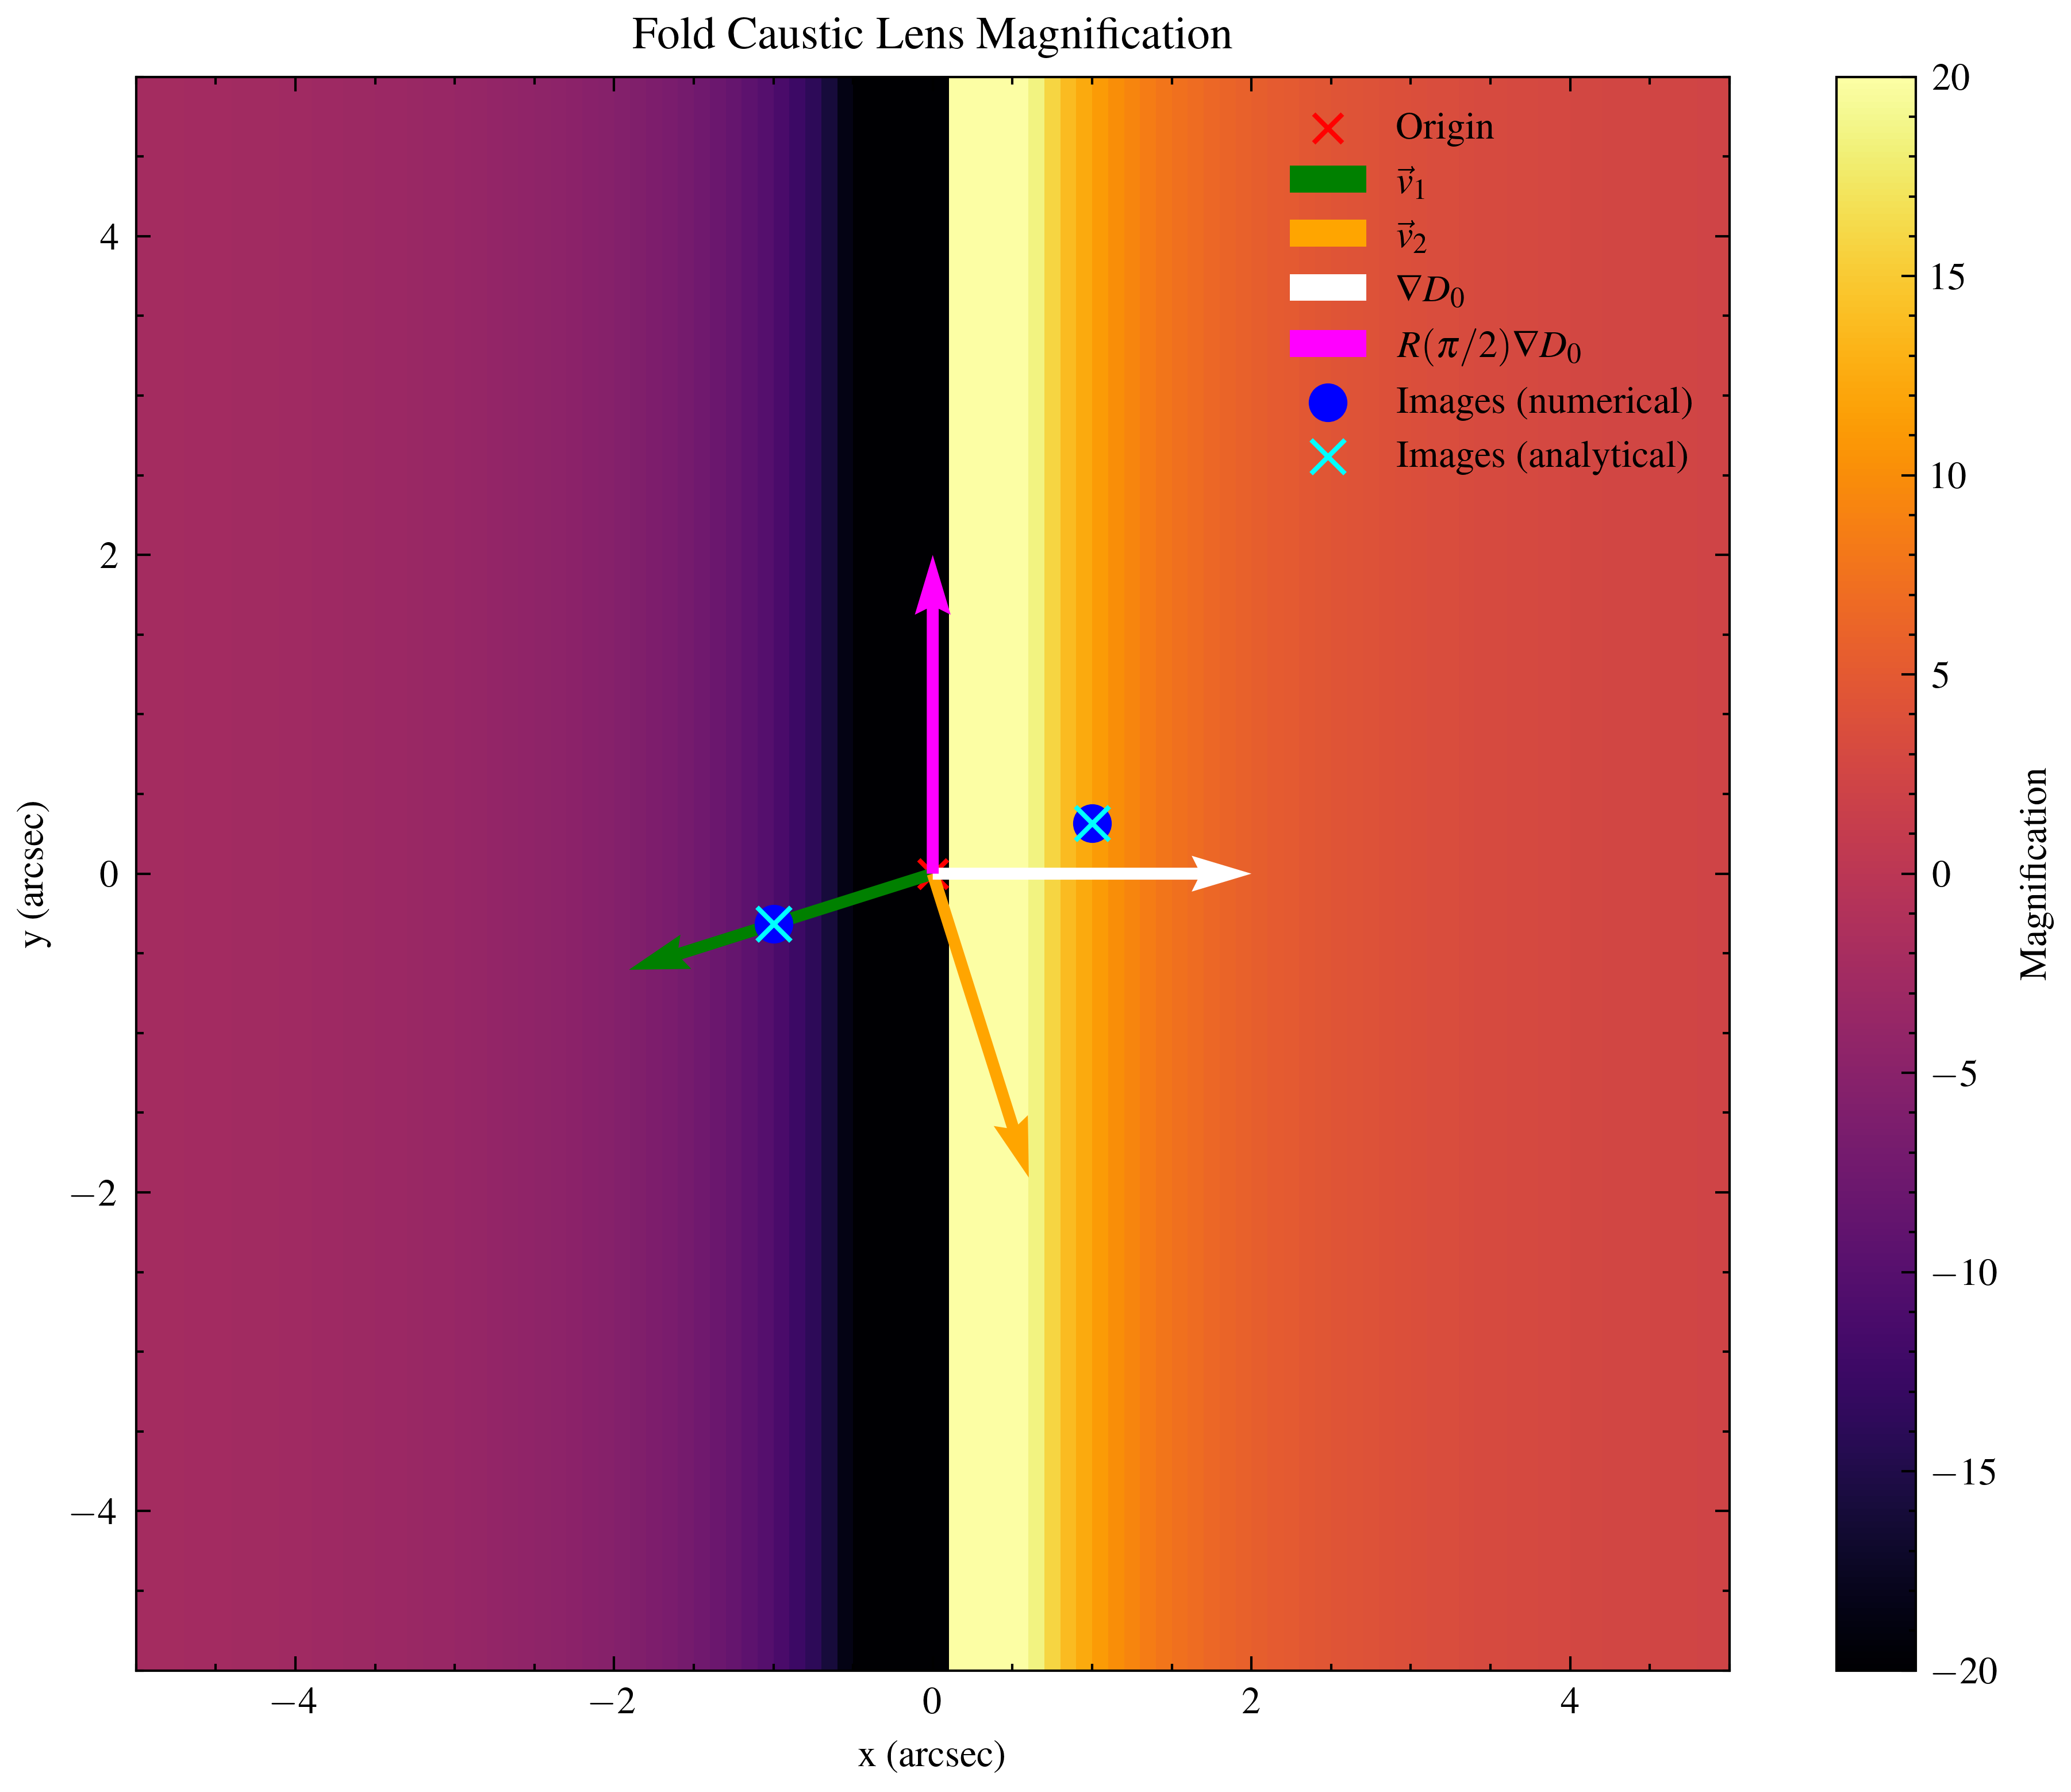

In [10]:
# Plot the absolute value of the magnification, the image positions, and eigenvectors:
plt.figure(figsize=(8, 6))
im = plt.imshow(Mu, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='inferno', vmin=-20, vmax=20) # Magnifications
cbar = plt.colorbar(im)
cbar.set_label('Magnification')
plt.scatter(0,0, marker='x', color='red', label='Origin') # Source positions
# Plot eigenvectors from 0:
plt.quiver(0, 0, v1[0], v1[1], color='green', scale=5, label=r"$\vec v_1$")
plt.quiver(0, 0, v2[0], v2[1], color='orange', scale=5, label=r"$\vec v_2$")
# Plot the nabla_detA vector from 0:
plt.quiver(0, 0, nabla_detA[0]/np.linalg.norm(nabla_detA), nabla_detA[1]/np.linalg.norm(nabla_detA), color='white', scale=5, label=r"$\nabla D_0$")
# Plot the rotated nabla_detA vector from 0:
plt.quiver(0, 0, nabla_detA_rot[0]/np.linalg.norm(nabla_detA_rot), nabla_detA_rot[1]/np.linalg.norm(nabla_detA_rot), color='magenta', scale=5, label=r"$R(\pi/2) \nabla D_0$")
# Plot the images:
plt.scatter(img[:,0], img[:,1], color='blue', s=50, label='Images (numerical)') # Images
plt.scatter(image_positions[:,0], image_positions[:,1], marker='x', color='cyan', s=50, edgecolor='black', label='Images (analytical)') # Images
plt.xlabel('x (arcsec)')
plt.ylabel('y (arcsec)')
plt.title('Fold Caustic Lens Magnification')
plt.legend()
plt.show()